In [1]:
%run imports.py

/home/ayush/miniconda3/envs/scan/lib/python3.8/site-packages/pymatgen/ext/matproj.py:454: DeprecationWarning:

__init__ is deprecated
MaterialsProjectCompatibility will be updated with new correction classes as well as new values of corrections and uncertainties in 2020



Imports successfully loaded


In [2]:
A = np.load('data/A.npy')
A_scaled = np.load('data/A_scaled.npy')
b = np.load('data/b.npy')
b = np.abs(b) > 0.04

In [3]:
N = A.shape[0]
n = int(0.9*N)
print(N, 'total data points,', n, '(90%) used for model development')
A_train, A_test = A_scaled[:n], A_scaled[n:]
b_train, b_test = b[:n], b[n:]

426 total data points, 383 (90%) used for model development


In [4]:
classifier = RandomForestClassifier()
classifier.fit(A_train, b_train)
accuracy_score(classifier.predict(A_test), b_test)

0.6976744186046512

In [5]:
forest_classifier = RandomForestClassifier()
parameters = {'n_estimators': [10, 100, 1000], 
              'max_depth': [2, 8, 128, None]}
grid_search = GridSearchCV(forest_classifier, parameters, cv=10, scoring=make_scorer(accuracy_score))
grid_search.fit(A_train, b_train)
print(grid_search.best_params_)

{'max_depth': 2, 'n_estimators': 10}


In [6]:
optimized_classifier = RandomForestClassifier(max_depth=2, n_estimators=100)
optimized_classifier.fit(A_train, b_train)
accuracy_score(optimized_classifier.predict(A_test), b_test)

0.6976744186046512

In [7]:
cv_scores = cross_val_score(RandomForestClassifier(), A_train, b_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

Accuracy: 0.68 (+/- 0.06)


In [8]:
feature_labels = []
for i in range(1, 13):
    feature_labels += ['Well {} mean'.format(i), 'Well {} std'.format(i), 'Well {} max'.format(i)]
feature_labels += ['Squared mean difference of means', 
                   'Squared mean difference of stds', 
                   'Squared mean difference of maxes']

In [9]:
%run classifiers.py

In [10]:
imps = dropcol_importances(optimized_classifier, A_train, b_train)
print(imps)

0.7389033942558747
0.7336814621409922
0.7336814621409922
0.7362924281984334
0.7362924281984334
0.7336814621409922
0.7362924281984334
0.7389033942558747
0.7362924281984334
0.741514360313316
0.7389033942558747
0.7389033942558747
0.7389033942558747
0.7441253263707572
0.7441253263707572
0.741514360313316
0.7389033942558747
0.7362924281984334
0.7336814621409922
0.7336814621409922
0.7336814621409922
0.7336814621409922
0.7336814621409922
0.7362924281984334
0.7362924281984334
0.7362924281984334
0.7362924281984334
0.7362924281984334
0.7336814621409922
0.7336814621409922
0.7310704960835509
0.7310704960835509
0.7310704960835509
0.7310704960835509
0.7310704960835509
0.7336814621409922
0.7362924281984334
0.7362924281984334
0.7336814621409922
0.7310704960835509
[ 0.00522193  0.00522193  0.00261097  0.00261097  0.00522193  0.00261097
  0.          0.00261097 -0.00261097  0.          0.          0.
 -0.00522193 -0.00522193 -0.00261097  0.          0.00261097  0.00522193
  0.00522193  0.00522193  0.005

In [11]:
imps2 = permutation_importances(optimized_classifier, A_train, b_train, oob_classifier_accuracy)
print(imps2)

0.6997389033942559
0.6997389033942559
0.7023498694516971
0.7049608355091384
0.6971279373368147
0.6997389033942559
0.6997389033942559
0.6971279373368147
0.7023498694516971
0.7023498694516971
0.6945169712793734
0.6997389033942559
0.6997389033942559
0.7023498694516971
0.6997389033942559
0.6997389033942559
0.6971279373368147
0.6997389033942559
0.6997389033942559
0.6997389033942559
0.7023498694516971
0.6997389033942559
0.6971279373368147
0.6997389033942559
0.6997389033942559
0.6971279373368147
0.7049608355091384
0.6997389033942559
0.6971279373368147
0.6997389033942559
0.6971279373368147
0.7023498694516971
0.6971279373368147
0.7023498694516971
0.6945169712793734
0.6971279373368147
0.6997389033942559
0.6971279373368147
0.6997389033942559
0.6997389033942559
[ 0.         -0.00261097 -0.00522193  0.00261097  0.          0.
  0.00261097 -0.00261097 -0.00261097  0.00522193  0.          0.
 -0.00261097  0.          0.          0.00261097  0.          0.
  0.         -0.00261097  0.          0.00261

In [12]:
def plot_importances(imps):
    xvals = [i for i in range(39)]
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.bar(xvals, height=imps)
    plt.xticks(xvals, feature_labels, rotation=90)
    plt.show()

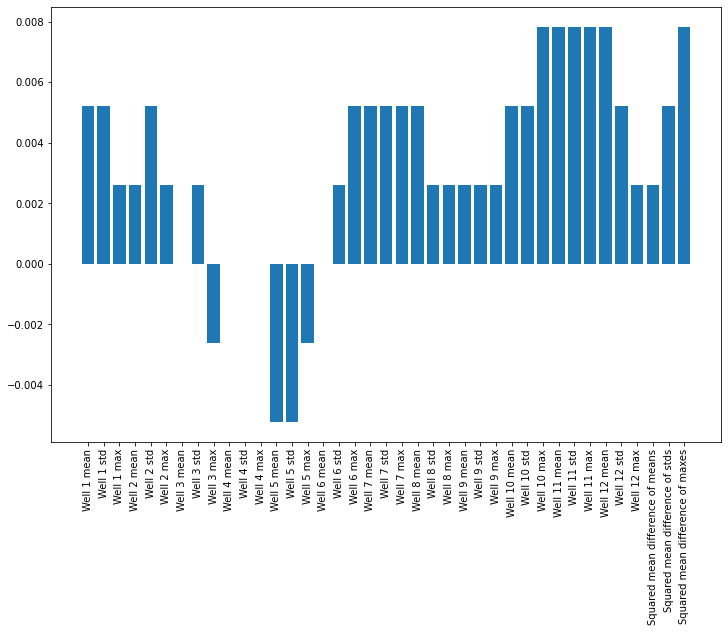

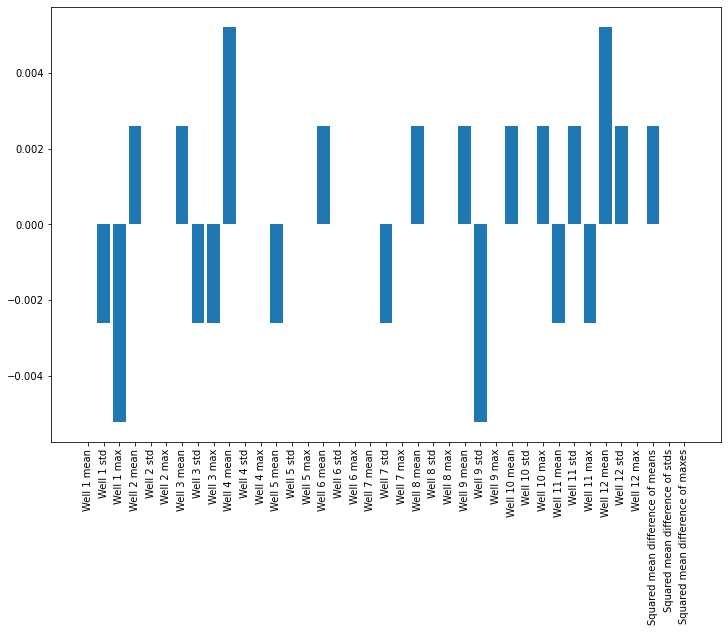

In [13]:
plot_importances(imps)
plot_importances(imps2)

In [14]:
embedded = TSNE(n_components=3).fit_transform(A_train)

In [15]:
trues_x, trues_y, trues_z, falses_x, falses_y, falses_z = [], [], [], [], [], []
for i in range(len(embedded)):
    if b_train[i]:
        trues_x.append(embedded[i][0])
        trues_y.append(embedded[i][1])
        trues_z.append(embedded[i][2])
    else:
        falses_x.append(embedded[i][0])
        falses_y.append(embedded[i][1])
        falses_z.append(embedded[i][2])

In [18]:
fig = go.Figure()

fig.add_trace(go.Scatter3d(x=trues_x, y=trues_y, z=trues_z,
                    mode='markers',
                    name='high error'))
fig.add_trace(go.Scatter3d(x=falses_x, y=falses_y, z=falses_z,
                    mode='markers',
                    name='low error'))

fig.show()

In [17]:
np.array([[1],[2]]).flatten()

array([1, 2])